In [121]:
# import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [122]:
# Covid-19 SG dataset details

sheet_id = "1gFTNs_GtnTIyyVWXmsQxwdZpGbyicZM2HJcXvCf4b3k"
sheet_name = "Sheet1"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

In [123]:
# read Covid-19 SG dataset

sg_data = pd.read_csv(url)

In [124]:
# filter to include only columns A to AD

sg_data_filtered = sg_data.iloc[:, :30]

# EDA & Pre-processing

**Outliers will not be removed because of their importance in the Covid context.**

**No need for scaling as all features are of the same magnitude.**

**Can look into what other features can be included from the current ones through extrapolation.**

In [125]:
sg_data_filtered.head()

,Date,Daily Confirmed,False Positives Found,Cumulative Confirmed,Daily Discharged,Passed but not due to COVID,Cumulative Discharged,Discharged to Isolation,Still Hospitalised,Daily Deaths,...,Total Hospital Discharged MOH report,Requires Oxygen Supplementation,Linked community cases,Unlinked community cases,Phase,Cumulative Vaccine Doses,Cumulative Individuals Vaccinated,Cumulative Individuals Vaccination Completed,Perc population completed at least one dose,Perc population completed vaccination
0,2020-01-23,1,NaN,1,0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-24,2,NaN,3,0,0,0,0,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-25,1,NaN,4,0,0,0,0,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-26,0,NaN,4,0,0,0,0,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-27,1,NaN,5,0,0,0,0,5,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [126]:
sg_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646 entries, 0 to 645
Data columns (total 30 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Date                                          646 non-null    object 
 1   Daily Confirmed                               646 non-null    int64  
 2   False Positives Found                         537 non-null    float64
 3   Cumulative Confirmed                          646 non-null    int64  
 4   Daily Discharged                              646 non-null    int64  
 5   Passed but not due to COVID                   646 non-null    int64  
 6   Cumulative Discharged                         646 non-null    int64  
 7   Discharged to Isolation                       646 non-null    int64  
 8   Still Hospitalised                            646 non-null    int64  
 9   Daily Deaths                                  646 non-null    int

In [127]:
# convert date to columns: year, month, day before dropping date column

sg_data_filtered["Date"] = pd.to_datetime(sg_data_filtered["Date"])
sg_data_filtered["Year"] = sg_data_filtered["Date"].dt.year
sg_data_filtered["Month"] = sg_data_filtered["Date"].dt.month
sg_data_filtered["Day"] = sg_data_filtered["Date"].dt.day
sg_data_filtered.drop("Date", axis=1, inplace=True)

In [128]:
# convert NaN values for phase to None

sg_data_filtered["Phase"] = sg_data_filtered["Phase"].fillna("None")

In [129]:
# change to one-hot dummy for phase

sg_data_filtered = pd.concat([sg_data_filtered, pd.get_dummies(sg_data_filtered['Phase'], prefix = 'Phase_=')], axis = 1).drop('Phase', axis = 1)

In [130]:
# convert percentage for Perc population completed at least one dose & Perc population completed vaccination

sg_data_filtered["Perc population completed at least one dose"] = [int(perc.split("%")[0])/100 if type(perc) == str else 0 for perc in sg_data_filtered["Perc population completed at least one dose"]]
sg_data_filtered["Perc population completed vaccination"] = [int(perc.split("%")[0])/100 if type(perc) == str else 0 for perc in sg_data_filtered["Perc population completed vaccination"]]

In [131]:
# convert all NaN values present to zeros for the rest of the columns (if data is unavailable, just treat as 0)

sg_data_filtered.fillna(0, inplace=True)

In [132]:
# check to see if NaN values still present

sg_data_filtered.isnull().values.any()

False

In [133]:
# check column info after pre-processing

sg_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646 entries, 0 to 645
Data columns (total 40 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Daily Confirmed                               646 non-null    int64  
 1   False Positives Found                         646 non-null    float64
 2   Cumulative Confirmed                          646 non-null    int64  
 3   Daily Discharged                              646 non-null    int64  
 4   Passed but not due to COVID                   646 non-null    int64  
 5   Cumulative Discharged                         646 non-null    int64  
 6   Discharged to Isolation                       646 non-null    int64  
 7   Still Hospitalised                            646 non-null    int64  
 8   Daily Deaths                                  646 non-null    int64  
 9   Cumulative Deaths                             646 non-null    int

<AxesSubplot:>

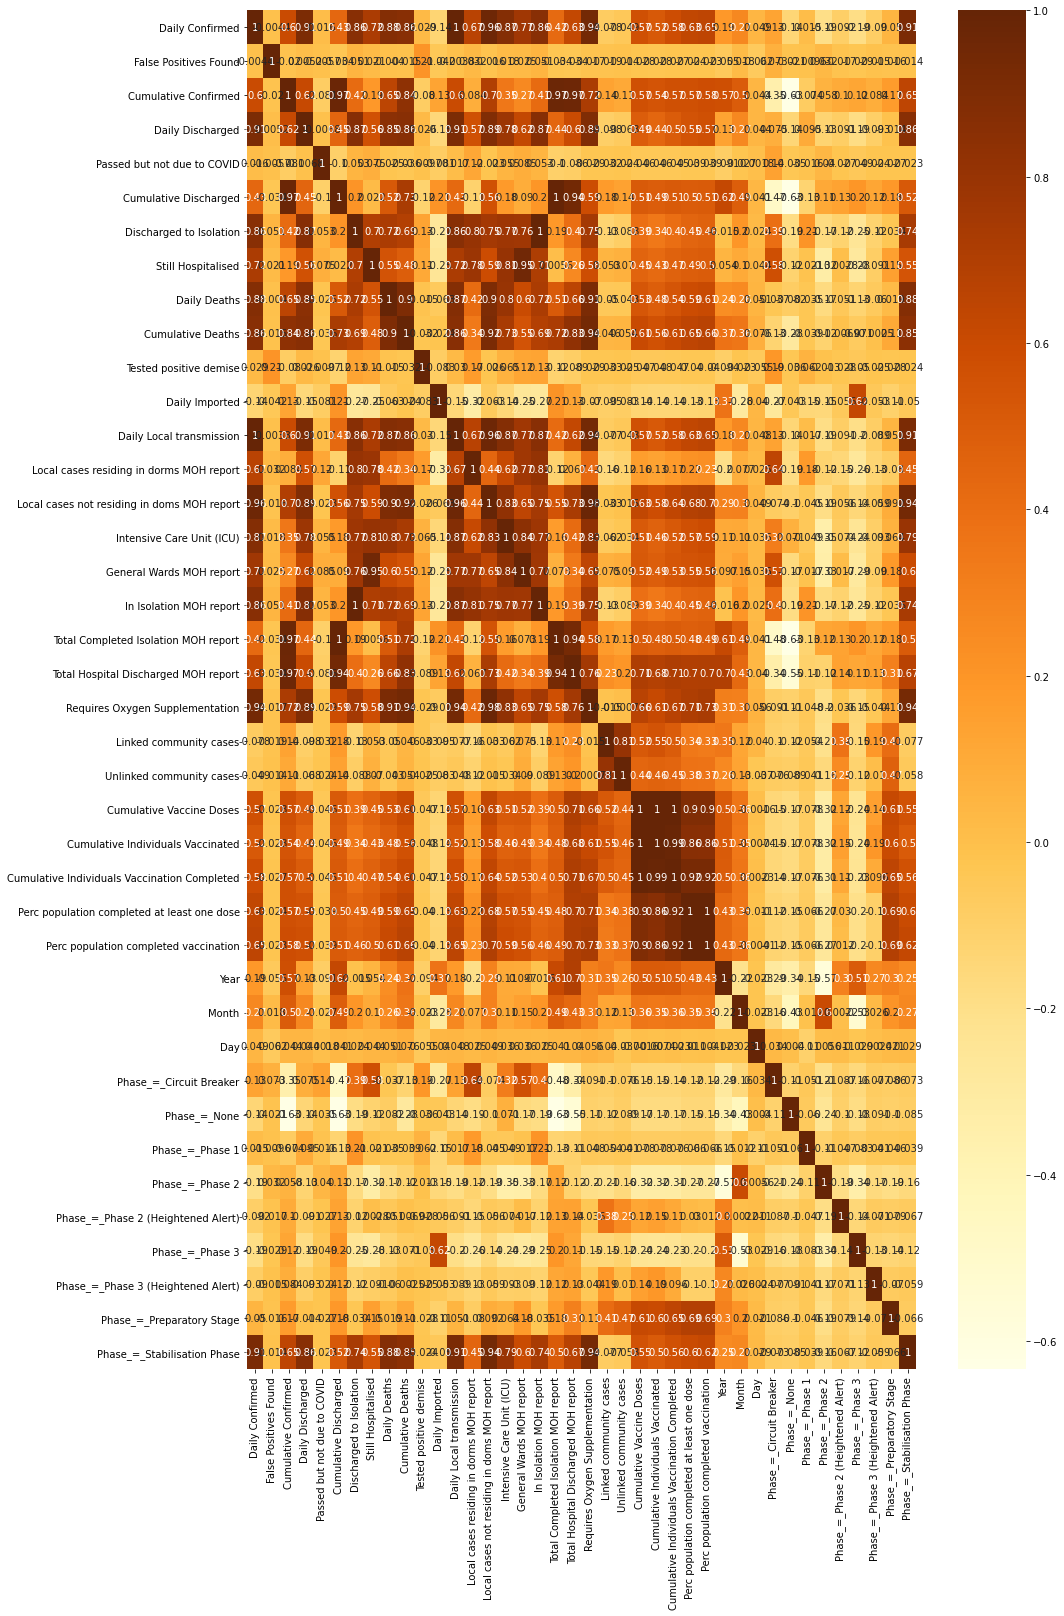

In [134]:
# corr. heatmap

plt.figure(figsize=(15,25))
sns.heatmap(sg_data_filtered.corr(), cmap='YlOrBr', annot=True)

In [135]:
# understanding correlation of all variables to imported cases (can change accordingly to the variable you are trying to predict)

sg_data_filtered.corr()["Intensive Care Unit (ICU)"].sort_values(ascending=False)

Intensive Care Unit (ICU)                       1.000000
Daily Local transmission                        0.873208
Daily Confirmed                                 0.872966
General Wards MOH report                        0.842387
Requires Oxygen Supplementation                 0.833469
Local cases not residing in doms MOH report     0.828385
Still Hospitalised                              0.807402
Daily Deaths                                    0.799928
Phase_=_Stabilisation Phase                     0.790834
Daily Discharged                                0.781313
In Isolation MOH report                         0.774244
Discharged to Isolation                         0.772242
Cumulative Deaths                               0.734764
Local cases residing in dorms MOH report        0.616241
Perc population completed vaccination           0.585884
Perc population completed at least one dose     0.571483
Cumulative Individuals Vaccination Completed    0.520270
Cumulative Vaccine Doses       

# Train Test Split

In [136]:
# change y variable accordingly to what is of interest

X = sg_data_filtered.drop("Intensive Care Unit (ICU)", axis=1)
y = sg_data_filtered["Intensive Care Unit (ICU)"]

In [137]:
# split using 25% for test as amount of data isn't much so that we've got more points to test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression

In [138]:
# build multiple linear regression model

regression = LinearRegression()
regression.fit(X_train, y_train)
pred = regression.predict(X_test)

In [139]:
# assessing model

train_adjusted_r2 = 1 - (1-regression.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-regression.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for LR")
print(f"MAE: {mean_absolute_error(y_test, pred)}")
print(f"MSE: {mean_squared_error(y_test, pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred))}")
print(f"R-squared score for train: {regression.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {regression.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(regression, X, y, cv=5)), 4)}")

Evaluation Metrics for LR
MAE: 2.0528687141355757
MSE: 13.12909986790596
RMSE: 3.6234099778945743
R-squared score for train: 0.956996679963974
Adjusted R-squared score for train: 0.9542291395656158
R-squared score for test: 0.9198892771832466
Adjusted R-squared score for test: 0.9147336366059309
Cross Validation Score: -114.4366


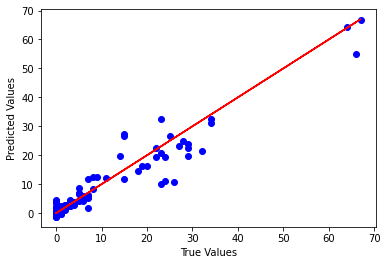

In [140]:
# For test set

# scatter for predictions
plt.scatter(y_test, pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

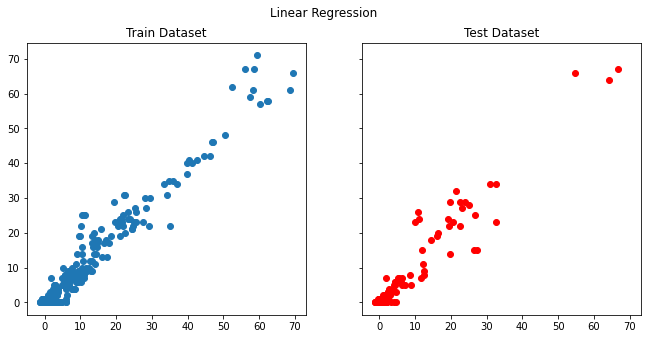

In [141]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(regression.predict(X_train), y_train)
ax[1].scatter(pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Linear Regression')

plt.show()

In [142]:
# find out feature importance

regr_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': regression.coef_
})

regr_importance = regr_importance.sort_values(by='Importance', ascending=False)
regr_importance

,Attribute,Importance
0,Daily Confirmed,8.227768e+07
25,Perc population completed at least one dose,6.351256e+01
38,Phase_=_Stabilisation Phase,5.770959e+00
30,Phase_=_Circuit Breaker,2.894318e+00
37,Phase_=_Preparatory Stage,2.433362e+00
7,Still Hospitalised,1.750005e+00
6,Discharged to Isolation,1.749058e+00
9,Cumulative Deaths,1.696228e+00
5,Cumulative Discharged,1.649647e+00
10,Tested positive demise,9.360704e-01


# Ridge Regression

In [143]:
# build lasso model

ridge = Ridge()
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.06357e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


In [144]:
# assessing model

train_adjusted_r2 = 1 - (1-ridge.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-ridge.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for Ridge")
print(f"MAE: {mean_absolute_error(y_test, ridge_pred)}")
print(f"MSE: {mean_squared_error(y_test, ridge_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, ridge_pred))}")
print(f"R-squared score for train: {ridge.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {ridge.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(ridge, X, y, cv=5)), 4)}")

Evaluation Metrics for Ridge
MAE: 2.0469217356258573
MSE: 13.358833006646917
RMSE: 3.654973735425046
R-squared score for train: 0.9562442366309928
Adjusted R-squared score for train: 0.9534282716617002
R-squared score for test: 0.9184874988446959
Adjusted R-squared score for test: 0.9132416448099486
Cross Validation Score: -96.9452


C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.43927e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.92094e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.99809e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.63869e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


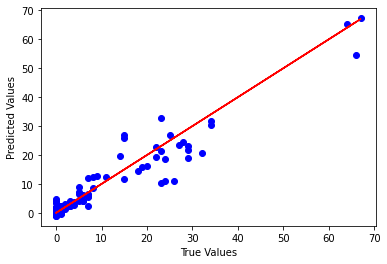

In [145]:
# For test set

# scatter for predictions
plt.scatter(y_test, ridge_pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

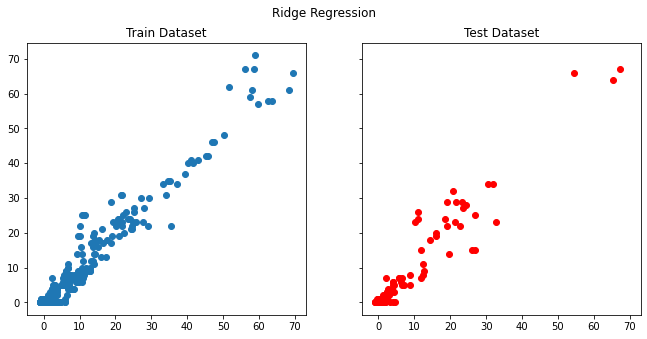

In [146]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(ridge.predict(X_train), y_train)
ax[1].scatter(ridge_pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Ridge Regression')

plt.show()

In [147]:
# find out feature importance

ridge_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': ridge.coef_
})

ridge_importance = ridge_importance.sort_values(by='Importance', ascending=False)
ridge_importance

,Attribute,Importance
25,Perc population completed at least one dose,3.686119
30,Phase_=_Circuit Breaker,3.535945
26,Perc population completed vaccination,2.443880
38,Phase_=_Stabilisation Phase,2.065484
7,Still Hospitalised,1.513447
6,Discharged to Isolation,1.512377
9,Cumulative Deaths,1.470742
5,Cumulative Discharged,1.416734
27,Year,0.933339
10,Tested positive demise,0.640610


# Important Features & Future Prediction

In [151]:
important_X_train = X_train[["Passed but not due to COVID","Tested positive demise","Cumulative Discharged","Cumulative Deaths","Discharged to Isolation","Still Hospitalised","Perc population completed vaccination","Perc population completed at least one dose","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()
important_X_test = X_test[["Passed but not due to COVID","Tested positive demise","Cumulative Discharged","Cumulative Deaths","Discharged to Isolation","Still Hospitalised","Perc population completed vaccination","Perc population completed at least one dose","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()

In [152]:
# training the model based on the few features extracted
impt_ridge = Ridge()
impt_ridge.fit(important_X_train, y_train)
impt_ridge_pred = impt_ridge.predict(important_X_test)

In [153]:
# evaluating the new model with few select features
impt_train_adjusted_r2 = 1 - (1-impt_ridge.score(important_X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
impt_test_adjusted_r2 = 1 - (1-impt_ridge.score(important_X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for Ridge")
print(f"MAE: {mean_absolute_error(y_test, impt_ridge_pred)}")
print(f"MSE: {mean_squared_error(y_test, impt_ridge_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, impt_ridge_pred))}")
print(f"R-squared score for train: {impt_ridge.score(important_X_train, y_train)}")
print(f"Adjusted R-squared score for train: {impt_train_adjusted_r2}")
print(f"R-squared score for test: {impt_ridge.score(important_X_test, y_test)}")
print(f"Adjusted R-squared score for test: {impt_test_adjusted_r2}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(impt_ridge, X, y, cv=5)), 4)}")

Evaluation Metrics for Ridge
MAE: 2.5572056899277342
MSE: 19.657735664928047
RMSE: 4.433704508075391
R-squared score for train: 0.9326043679673587
Adjusted R-squared score for train: 0.9282670253117926
R-squared score for test: 0.8800530555101009
Adjusted R-squared score for test: 0.8723336976963946
Cross Validation Score: -96.9452


C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.43927e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.92094e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.99809e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.63869e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
